---
---

<h1 align='center'> Anamoly Detection </h1>
<h2 align='center'> Transfer-Learning Models: Bert+(ML/NN) </h2>

---
---

In [2]:
#Import Libraries and upload clean data into workspace
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

import warnings
warnings.filterwarnings('ignore')

## Read File

In [3]:
import pandas as pd
data = pd.read_csv("cleaned_2k.data.csv")

#expanding the dispay of text sms column
pd.set_option('display.max_colwidth', -1)

In [4]:
from google.colab import data_table
data_table.enable_dataframe_formatter()
#Print the dataframe
data

,X_data,Y_data
0,1 81109 203615 148 INFO dfs DataNode PacketResponder PacketResponder 1 for block blk38865049064139660 terminating dc2c74b7,0
1,2 81109 203807 222 INFO dfs DataNode PacketResponder PacketResponder 0 for block blk6952295868487656571 terminating dc2c74b7,0
2,3 81109 204005 35 INFO dfs FSNamesystem BLOCK NameSystem addStoredBlock blockMap updated 10 251 73 220 50010 is added to blk7128370237687728475 size 67108864 5d5de21c,0
3,4 81109 204015 308 INFO dfs DataNode PacketResponder PacketResponder 2 for block blk8229193803249955061 terminating dc2c74b7,0
4,5 81109 204106 329 INFO dfs DataNode PacketResponder PacketResponder 2 for block blk6670958622368987959 terminating dc2c74b7,0
...,...,...
1995,1996 81111 101621 24902 INFO dfs DataNode DataXceiver Receiving block blk4198733391373026104 src 10 251 106 10 46843 dest 10 251 106 10 50010 09a53393,0
1996,1997 81111 101735 26595 INFO dfs DataNode PacketResponder Received block blk5815145248455404269 of size 67108864 from 10 251 121 224 e3df2680,0
1997,1998 81111 101804 26494 INFO dfs DataNode DataXceiver Receiving block blk295306975763175640 src 10 250 9 207 53270 dest 10 250 9 207 50010 09a53393,0
1998,1999 81111 101954 26414 INFO dfs DataNode PacketResponder PacketResponder 0 for block blk5225719677049010638 terminating dc2c74b7,0


## Exploratory Data Analysis

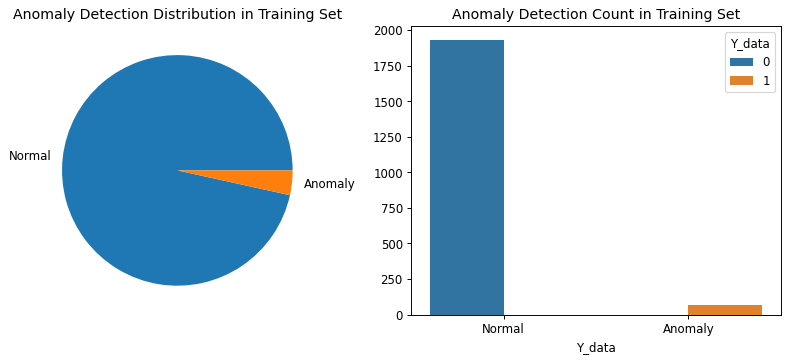

In [4]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), dpi=85)
plt.tight_layout()

data.groupby('Y_data').count()['X_data'].plot(kind='pie', ax=axes[0], labels=['Normal', 'Anomaly'])
sns.countplot(x=data['Y_data'], hue=data['Y_data'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Normal', 'Anomaly'])
axes[0].tick_params(axis='x', labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)
axes[1].tick_params(axis='x', labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)

axes[0].set_title('Anomaly Detection Distribution in Training Set', fontsize=12)
axes[1].set_title('Anomaly Detection Count in Training Set', fontsize=12)

plt.show()

## Specs and Dependencies

In [6]:
!pip3 install tensorflow_text
!pip3 install tensorflow_hub
!pip3 install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
#cpu
split_bar = '='*20
print(f"{split_bar} CPU {split_bar}")
cpu_info = !lscpu
for inf_item in cpu_info.get_list():
  print(inf_item)

==================== CPU ====================
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hy

In [8]:
print(f"{split_bar} RAM {split_bar}")
!free -h #ram
print(f"{split_bar} CUDA {split_bar}")
!nvcc --version #cuda

==================== RAM ====================
              total        used        free      shared  buff/cache   available
Mem:            12G        884M        8.5G        1.3M        3.3G         11G
Swap:            0B          0B          0B
==================== CUDA ====================
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [9]:
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
!nvidia-smi

/device:GPU:0
Num GPUs Available:  1
Fri Sep 23 23:22:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    30W /  70W |    324MiB / 15109MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                   

## **Bert Models** (*Hugging Face*)

In [5]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

print('Available Pretrained Models:',*list(map_name_to_handle.keys()), sep = "\n")

Available Pretrained Models:
bert_en_uncased_L-12_H-768_A-12
bert_en_cased_L-12_H-768_A-12
bert_multi_cased_L-12_H-768_A-12
small_bert/bert_en_uncased_L-2_H-128_A-2
small_bert/bert_en_uncased_L-2_H-256_A-4
small_bert/bert_en_uncased_L-2_H-512_A-8
small_bert/bert_en_uncased_L-2_H-768_A-12
small_bert/bert_en_uncased_L-4_H-128_A-2
small_bert/bert_en_uncased_L-4_H-256_A-4
small_bert/bert_en_uncased_L-4_H-512_A-8
small_bert/bert_en_uncased_L-4_H-768_A-12
small_bert/bert_en_uncased_L-6_H-128_A-2
small_bert/bert_en_uncased_L-6_H-256_A-4
small_bert/bert_en_uncased_L-6_H-512_A-8
small_bert/bert_en_uncased_L-6_H-768_A-12
small_bert/bert_en_uncased_L-8_H-128_A-2
small_bert/bert_en_uncased_L-8_H-256_A-4
small_bert/bert_en_uncased_L-8_H-512_A-8
small_bert/bert_en_uncased_L-8_H-768_A-12
small_bert/bert_en_uncased_L-10_H-128_A-2
small_bert/bert_en_uncased_L-10_H-256_A-4
small_bert/bert_en_uncased_L-10_H-512_A-8
small_bert/bert_en_uncased_L-10_H-768_A-12
small_bert/bert_en_uncased_L-12_H-128_A-2
small

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# Choose the Model
bert_model_name = 'small_bert/bert_en_uncased_L-12_H-768_A-12' 

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

#tf.compat.v1.disable_eager_execution()
bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess, name='preprocess', trainable=False)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder, name='encoder', trainable=False)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Feature Extraction

In [12]:
from tqdm import tqdm
import csv
import psutil

#features = []
with open("BertFeatures_2k.csv",'w') as f:
  writer = csv.writer(f, delimiter=',', lineterminator='\n')
  writer.writerow(list(range(768)))
  
  for i in tqdm(data['X_data']):
    # clear tensorflow ram when it exceeds 90 percent of ram usage
    if psutil.virtual_memory().percent > 90:
      tf.keras.backend.clear_session()
    
    bert_results = bert_encoder(bert_preprocess([i]))
    bert_out = bert_results["pooled_output"].numpy()[0]
    #print(bert_out.shape)
    #features.append(bert_out)
    writer.writerow(bert_out)
  #features = np.array(features)

100%|██████████| 2000/2000 [06:20<00:00,  5.25it/s]


In [15]:
#Saving features
#features = features.reshape(len(data),768)
#np.save('bert-features',features)
features = pd.read_csv("BertFeatures_2k.csv") 
features.shape

(2000, 768)

---
# **Transfer Learning Approches**
*restart the kernel for faster run-time as features are extracted from bert transformer and saved*

In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
x = pd.read_csv("BertFeatures_2k.csv")
data = pd.read_csv("cleaned_2k.data.csv")
y = data['Y_data'].apply(lambda x: -1 if x == 0 else 1)

---
### **1--> ML models with Hyper-parameter tuning**
---

## Train/Test/Validation Data-Split

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# split train dataset into train, validation and test sets
train_features, test_features, train_labels, test_labels = train_test_split(x, y,
                                                                            random_state=2022, 
                                                                            test_size=0.2, 
                                                                            stratify=y)

class_names = ['Normal','Anomaly']

#### *Searching for the best model*
These above features-data is given as inputs for ML-Classifiers and best out them is found

In [3]:
from sklearn.svm import OneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDOneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

names = ["Lin OneClassSVM", "Poly OneClassSVM", "RBF OneClassSVM", 
         "Sig OneClassSVM", "Lin OneClassSVM - SGD", "LOF", "IsolationForest", 
         "Lin SVM", "Poly SVM", "RBF SVM", "Sig SVM", "lbfgs Log-Reg", 
         "saga Log-Reg", "SGD", "Naive Bayes", "Gaussian Process", "Decision Tree", 
         "Random Forest", "KNN", "GradientBoostingClassifier", "Neural Net", 
         "AdaBoost", "QDA", "LGBM", "XGB"]

classifiers = [OneClassSVM(kernel='linear',max_iter=10000,verbose=1), OneClassSVM(kernel='poly',max_iter=10000,verbose=1), 
               OneClassSVM(kernel='rbf',max_iter=10000,verbose=1), OneClassSVM(kernel='sigmoid',max_iter=10000,verbose=1),
               SGDOneClassSVM(max_iter=10000,verbose=1), LocalOutlierFactor(n_neighbors=7,novelty=True), IsolationForest(verbose=1),
               SVC(kernel='linear',max_iter=10000,verbose=1), SVC(kernel='poly',max_iter=10000,verbose=1), 
               SVC(kernel='rbf',max_iter=10000,verbose=1), SVC(kernel='sigmoid',max_iter=10000,verbose=1),
               LogisticRegression(solver='lbfgs',verbose=1), LogisticRegression(solver='saga',verbose=1), SGDClassifier(verbose=1), 
               GaussianNB(), GaussianProcessClassifier(), DecisionTreeClassifier(max_depth=25), 
               RandomForestClassifier(max_depth=25,verbose=1), KNeighborsClassifier(n_neighbors=7), GradientBoostingClassifier(max_depth=5,verbose=1),
               MLPClassifier(max_iter=2500,early_stopping=True,verbose=1), AdaBoostClassifier(), 
               QuadraticDiscriminantAnalysis(), LGBMClassifier(verbose=1), XGBClassifier(verbose=1)]

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

def runML():
    for i in range(len(class_names)):
        print("CLASS -",i,"-->",class_names[i])

    fig = plt.figure(figsize=(18,20))
    fig.tight_layout()
    nof_clsfrs = len(names)
    Metrics = {}
    
    print('\nClassification Report for each Classifier:')
    for i in range(nof_clsfrs):
        metric = []
        classifier = classifiers[i]
        plt.subplot(nof_clsfrs//5,5,i+1)
        plt.xticks([])
        plt.yticks([])
    
        print(f'\n\nClassifier: {str(classifier)[0:25]}...')
        if 'KMeans' in str(classifier):
            # for KMeans, we use the entire features data as it unsupervised
            start_time = time.time(); classifier.fit(x, y); metric.append(time.time() - start_time);
            metric.append(metric[-1]) # test run time is same
        else:
            start_time = time.time(); classifier.fit(train_features, train_labels); metric.append(time.time() - start_time); 
            start_time = time.time(); test_pred = classifier.predict(test_features); metric.append(time.time() - start_time);
        acc = accuracy_score(test_labels,test_pred) *100; metric.append(acc);
        Metrics[names[i]] = metric
        #print(f'Accuracy  is {acc}%, Report:')
        print(classification_report(test_labels, test_pred))
    
        plt.gca().set_title(names[i])
        CM = confusion_matrix(test_labels, test_pred)
        plt.imshow(CM,interpolation='nearest',cmap='summer')
        for (i, j), z in np.ndenumerate(CM):
            plt.text(j, i, z, ha='center', va='center')
        plt.xticks(np.arange(len(class_names)),class_names, fontsize=8)
        plt.yticks(np.arange(len(class_names)))
        plt.grid(False)
    plt.show()
    return Metrics

#### *Fitting and Ploting results*

CLASS - 0 --> Normal
CLASS - 1 --> Anomaly

Classification Report for each Classifier:


Classifier: OneClassSVM(kernel='linea...
[LibSVM]              precision    recall  f1-score   support

          -1       0.98      0.54      0.69       386
           1       0.05      0.64      0.09        14

    accuracy                           0.54       400
   macro avg       0.51      0.59      0.39       400
weighted avg       0.94      0.54      0.67       400



Classifier: OneClassSVM(kernel='poly'...
[LibSVM]              precision    recall  f1-score   support

          -1       0.98      0.54      0.69       386
           1       0.05      0.64      0.09        14

    accuracy                           0.54       400
   macro avg       0.51      0.59      0.39       400
weighted avg       0.94      0.54      0.67       400



Classifier: OneClassSVM(max_iter=1000...
[LibSVM]              precision    recall  f1-score   support

          -1       0.98      0.53      0.68       3

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


              precision    recall  f1-score   support

          -1       0.94      0.08      0.15       386
           1       0.03      0.86      0.06        14

    accuracy                           0.11       400
   macro avg       0.49      0.47      0.11       400
weighted avg       0.91      0.11      0.15       400



Classifier: SVC(kernel='linear', max_...
[LibSVM]              precision    recall  f1-score   support

          -1       0.96      1.00      0.98       386
           1       0.00      0.00      0.00        14

    accuracy                           0.96       400
   macro avg       0.48      0.50      0.49       400
weighted avg       0.93      0.96      0.95       400



Classifier: SVC(kernel='poly', max_it...
[LibSVM]              precision    recall  f1-score   support

          -1       0.96      1.00      0.98       386
           1       0.00      0.00      0.00        14

    accuracy                           0.96       400
   macro avg       0.48   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

          -1       0.96      1.00      0.98       386
           1       0.00      0.00      0.00        14

    accuracy                           0.96       400
   macro avg       0.48      0.50      0.49       400
weighted avg       0.93      0.96      0.95       400



Classifier: LogisticRegression(solver...
max_iter reached after 1 seconds
              precision    recall  f1-score   support

          -1       0.96      1.00      0.98       386
           1       0.00      0.00      0.00        14

    accuracy                           0.96       400
   macro avg       0.48      0.50      0.49       400
weighted avg       0.93      0.96      0.95       400



Classifier: SGDClassifier(verbose=1)...
-- Epoch 1
Norm: 69.84, NNZs: 768, Bias: -5.994982, T: 1600, Avg. loss: 71.895174
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 88.57, NNZs: 768, Bias: -5.943602, T: 3200, Avg. loss: 35.632791
Total training time: 0.01 sec

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished




Classifier: GaussianNB()...
              precision    recall  f1-score   support

          -1       0.96      0.29      0.45       386
           1       0.03      0.64      0.06        14

    accuracy                           0.30       400
   macro avg       0.49      0.47      0.25       400
weighted avg       0.93      0.30      0.43       400



Classifier: GaussianProcessClassifier...
              precision    recall  f1-score   support

          -1       0.96      1.00      0.98       386
           1       0.00      0.00      0.00        14

    accuracy                           0.96       400
   macro avg       0.48      0.50      0.49       400
weighted avg       0.93      0.96      0.95       400



Classifier: DecisionTreeClassifier(ma...
              precision    recall  f1-score   support

          -1       0.96      0.96      0.96       386
           1       0.00      0.00      0.00        14

    accuracy                           0.93       400
   macro avg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


              precision    recall  f1-score   support

          -1       0.96      1.00      0.98       386
           1       0.00      0.00      0.00        14

    accuracy                           0.96       400
   macro avg       0.48      0.50      0.49       400
weighted avg       0.93      0.96      0.95       400



Classifier: KNeighborsClassifier(n_ne...
              precision    recall  f1-score   support

          -1       0.96      1.00      0.98       386
           1       0.00      0.00      0.00        14

    accuracy                           0.96       400
   macro avg       0.48      0.50      0.49       400
weighted avg       0.93      0.96      0.95       400



Classifier: GradientBoostingClassifie...
      Iter       Train Loss   Remaining Time 
         1           0.2592           48.78s
         2           0.2418           47.12s
         3           0.2225           47.12s
         4           0.2059           46.74s
         5           0.1976       

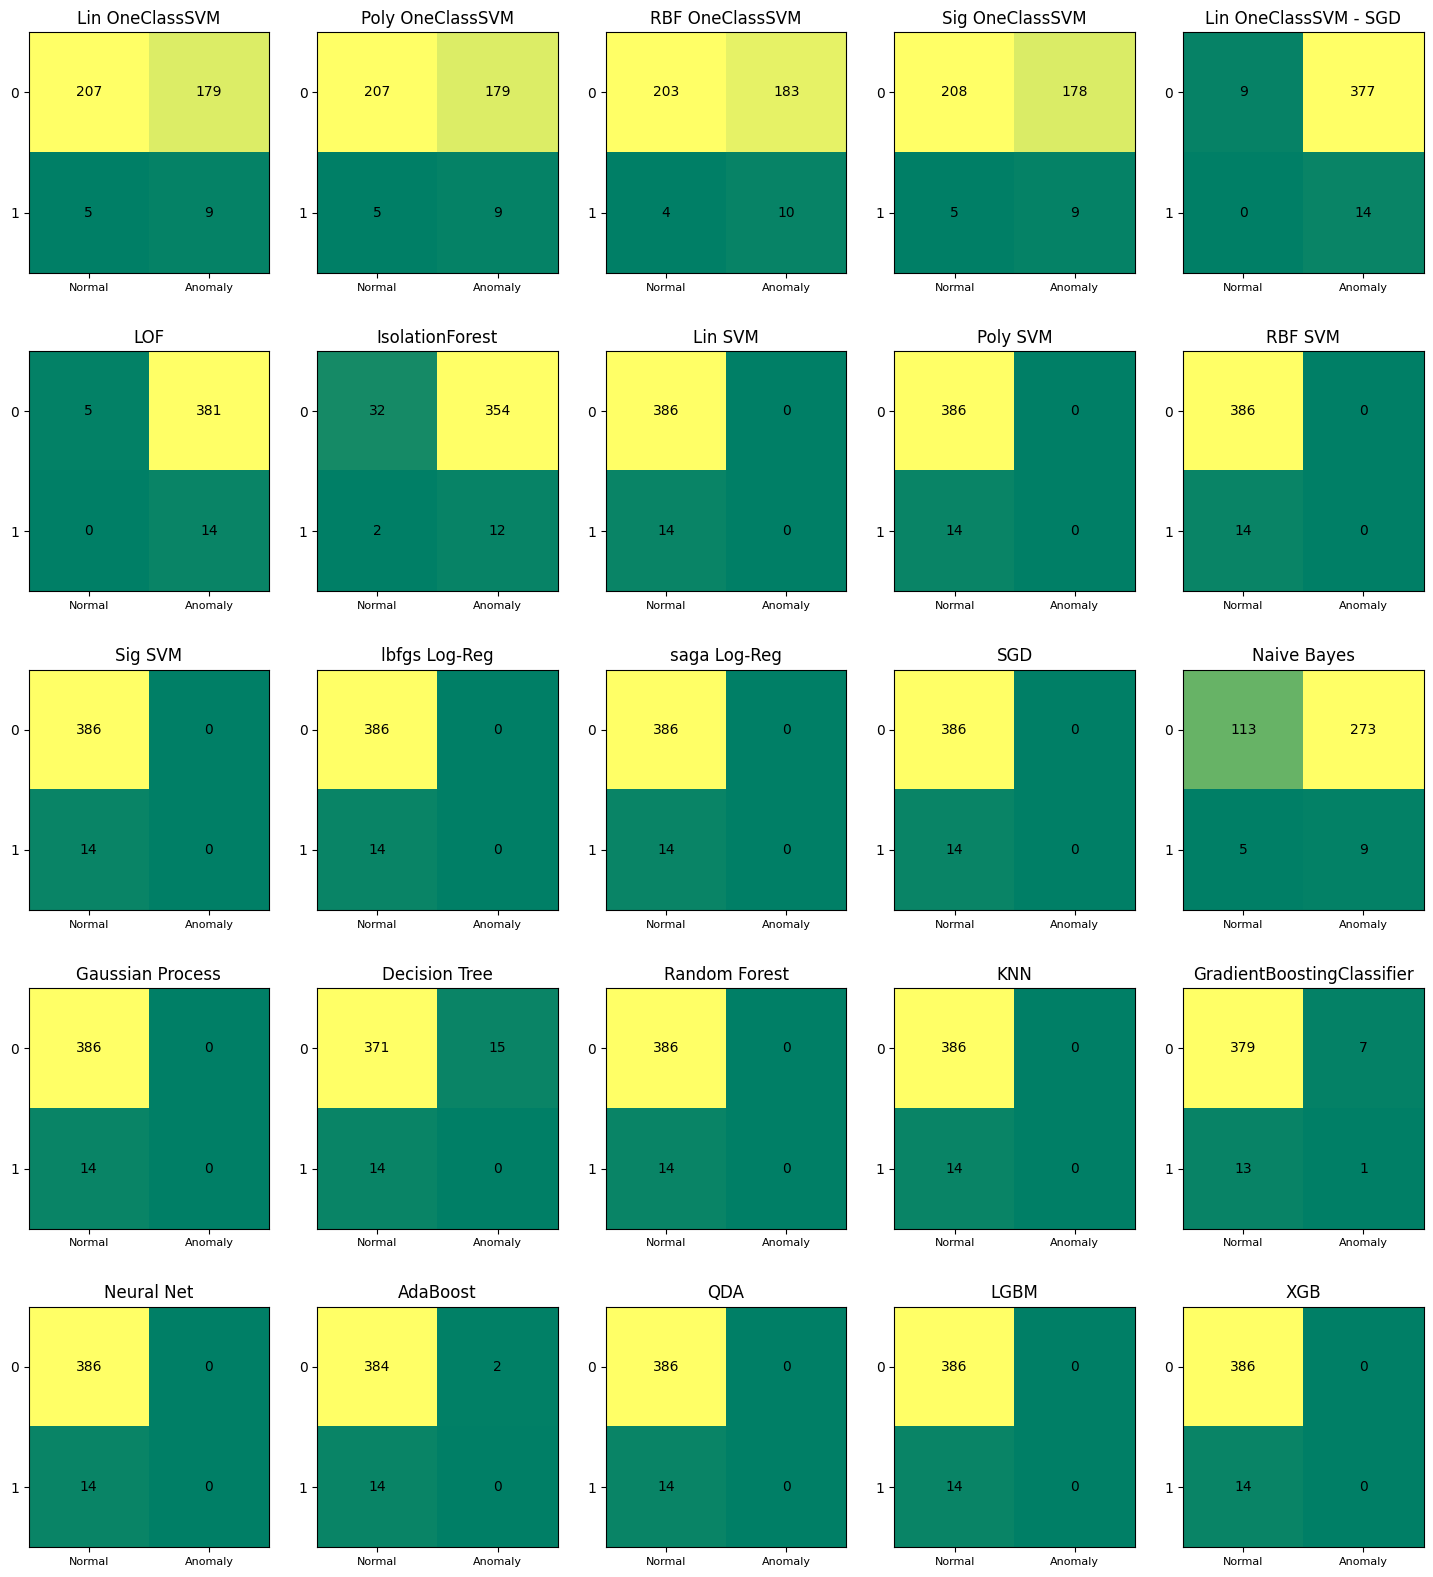

In [5]:
Metrics = runML()

In [6]:
result = pd.DataFrame(Metrics.values(), columns =['Training-time', 'Prediction-time', 'Accuracy'])
result.index = Metrics.keys()

print("\nClassifier for which max Accuracy is obtained:")
print(result.loc[result["Accuracy"].idxmax()])

print("\n\nClassifier for which min Training-time is obtained:")
print(result.loc[result["Training-time"].idxmin()])

print("\n\nClassifier for which min Prediction-time is obtained:")
print(result.loc[result["Prediction-time"].idxmin()])

print("\n\nResults of all the Classifiers:")
result.sort_values(by="Accuracy", ascending=False)


Classifier for which max Accuracy is obtained:
Training-time       0.224401
Prediction-time     0.015957
Accuracy           96.500000
Name: Lin SVM, dtype: float64


Classifier for which min Training-time is obtained:
Training-time       0.006058
Prediction-time     0.042097
Accuracy           96.500000
Name: KNN, dtype: float64


Classifier for which min Prediction-time is obtained:
Training-time       0.407284
Prediction-time     0.004987
Accuracy           96.500000
Name: Neural Net, dtype: float64


Results of all the Classifiers:


,Training-time,Prediction-time,Accuracy
saga Log-Reg,1.543119,0.006980,96.50
Sig SVM,0.098101,0.013930,96.50
LGBM,3.242710,0.016968,96.50
QDA,0.875950,0.012965,96.50
Neural Net,0.407284,0.004987,96.50
KNN,0.006058,0.042097,96.50
Random Forest,3.392451,0.018969,96.50
Gaussian Process,5.128629,0.929373,96.50
SGD,0.175531,0.006983,96.50
lbfgs Log-Reg,0.214736,0.005984,96.50


---
### **2--> Bert + Dense layers only approach**
---

## Train/Test/Validation Data-Split

In [12]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# split train dataset into train, validation and test sets
train_text, test_text, train_labels, test_labels = train_test_split(data['X_data'], data['Y_data'],
                                                                            random_state=2022, 
                                                                            test_size=0.2, 
                                                                            stratify=data['Y_data'])

class_names = ['Normal','Anomaly']

In [9]:
# change trainable parameter again
bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess, name='preprocess', trainable=True)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder, name='encoder', trainable=True)

In [10]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout1")(outputs['pooled_output'])
l = tf.keras.layers.Dense(2048, activation='relu', name="fc1")(l)
l = tf.keras.layers.Dense(2048, activation='relu', name="fc2")(l)
l = tf.keras.layers.Dropout(0.1, name="dropout2")(l)
l = tf.keras.layers.Dense(1024, activation='relu', name="fc3")(l)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


Model: "small_bert/bert_en_uncased_L-12_H-768_A-12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocess (KerasLayer)        {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}             

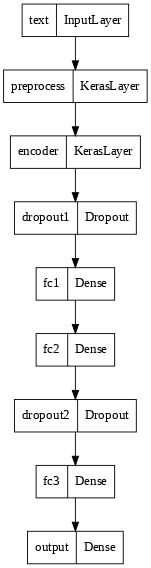

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model._name = bert_model_name
model.summary()
keras.utils.plot_model(model,dpi=65)

#### *Training and Results*

In [13]:
#Stop training when a monitored metric (here, accuracy) has stopped improving.
#patience: Number of epochs with no improvement after which training will be stopped.
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)

# Saving the best Trained model
model_file = model.name+'_Model.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_file, save_best_only=True)

tf.keras.backend.clear_session
history = model.fit(train_text, train_labels,
                    epochs=25,
                    validation_split=0.15,
                    callbacks=[early_stopping_cb, checkpoint_cb]
                   )

Epoch 1/25
43/43 [==============================] - 64s 1s/step - loss: 0.3939 - accuracy: 0.9250 - val_loss: 0.1344 - val_accuracy: 0.9708
Epoch 2/25
43/43 [==============================] - 41s 947ms/step - loss: 0.1665 - accuracy: 0.9647 - val_loss: 0.1786 - val_accuracy: 0.9708
Epoch 3/25
43/43 [==============================] - 47s 1s/step - loss: 0.1686 - accuracy: 0.9647 - val_loss: 0.1334 - val_accuracy: 0.9708
Epoch 4/25
43/43 [==============================] - 47s 1s/step - loss: 0.1711 - accuracy: 0.9647 - val_loss: 0.1321 - val_accuracy: 0.9708
Epoch 5/25
43/43 [==============================] - 40s 924ms/step - loss: 0.1631 - accuracy: 0.9647 - val_loss: 0.1481 - val_accuracy: 0.9708
Epoch 6/25
43/43 [==============================] - 40s 936ms/step - loss: 0.1583 - accuracy: 0.9647 - val_loss: 0.1322 - val_accuracy: 0.9708
Epoch 7/25
43/43 [==============================] - 40s 925ms/step - loss: 0.1602 - accuracy: 0.9647 - val_loss: 0.1384 - val_accuracy: 0.9708
Epoch 8/

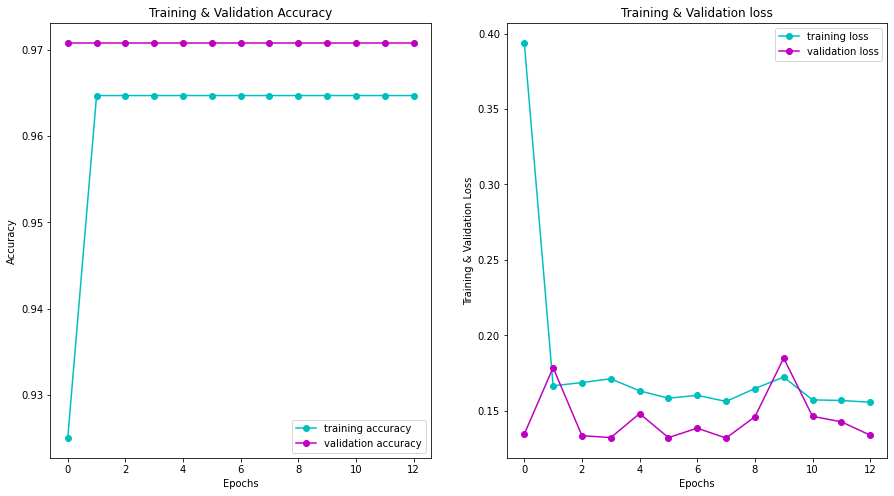

In [14]:
def plot_accuracy_and_loss_of_train_and_validation_dataset(history):
    train_acc=history.history['accuracy']
    train_loss=history.history['loss']
    val_acc=history.history['val_accuracy']
    val_loss=history.history['val_loss']
    epoch=[i for i in range(len(train_acc))]
    fig , ax=plt.subplots(1,2)
    fig.set_size_inches(15,8)
    ax[0].plot(epoch,train_acc,'co-',label='training accuracy')
    ax[0].plot(epoch,val_acc,'mo-',label='validation accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epoch,train_loss,'c-o',label='training loss')
    ax[1].plot(epoch,val_loss,'m-o',label='validation loss')
    ax[1].set_title('Training & Validation loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")

# incase of early stop
plot_accuracy_and_loss_of_train_and_validation_dataset(history)

#### **Evaluation**

In [15]:
#model = keras.models.load_model(model_file) # rollback to best model
loss,accuracy = model.evaluate(data['X_data'], data['Y_data'])
print("The accuracy of train text is : ",accuracy)

63/63 [==============================] - 21s 337ms/step - loss: 0.1506 - accuracy: 0.9655
The accuracy of train text is :  0.965499997138977


#### *Accuracy for each class*

In [16]:
print("Predicting Test data using the above Trained model...")
pred_Ids_of_test = model.predict(test_text)

Predicting Test data using the above Trained model...
13/13 [==============================] - 5s 361ms/step


In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predIdxs = np.argmax(pred_Ids_of_test, axis=1) # to get the indices of max value in each row
print(classification_report(test_labels, predIdxs,target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98       386
     Anomaly       0.00      0.00      0.00        14

    accuracy                           0.96       400
   macro avg       0.48      0.50      0.49       400
weighted avg       0.93      0.96      0.95       400



#### **Confusion Matrix**

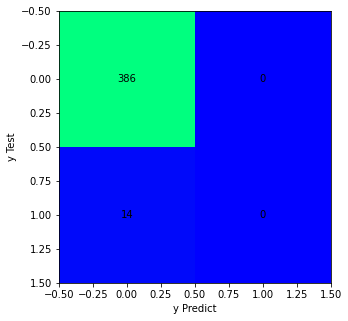

In [18]:
CM = confusion_matrix(test_labels, predIdxs)
# Plot confusion matrix
plt.figure(figsize = (5,5))
plt.imshow(CM,interpolation='nearest',cmap='winter')
for (i, j), z in np.ndenumerate(CM):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y Test")
plt.grid(False)
plt.show()

---